In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# SAM 3 Agent

This notebook shows an example of how an MLLM can use SAM 3 as a tool, i.e., "SAM 3 Agent", to segment more complex text queries such as "the leftmost child wearing blue vest".

## Env Setup

First install `sam3` in your environment using the [installation instructions](https://github.com/facebookresearch/sam3?tab=readme-ov-file#installation) in the repository.

In [1]:
import torch
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook. If your card doesn't support it, try float16 instead
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# inference mode for the whole notebook. Disable if you need gradients
torch.inference_mode().__enter__()

In [2]:
import os

SAM3_ROOT = "/home/scanar/endovis/models/sam3/"
print(f"Changing working directory to {SAM3_ROOT}")
os.chdir(SAM3_ROOT)

# setup GPU to use -  A single GPU is good with the purpose of this demo
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
_ = os.system("nvidia-smi")

Changing working directory to /home/scanar/endovis/models/sam3/
Sat Dec 27 03:59:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 8000                Off |   00000000:3B:00.0 Off |                    0 |
| N/A   66C    P0             74W /  250W |     167MiB /  46080MiB |      0%      Default |
|                                         |                        |        

## Build SAM3 Model

In [3]:
import sam3
from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

sam3_root = os.path.dirname(sam3.__file__)
bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
model = build_sam3_image_model(bpe_path=bpe_path)
processor = Sam3Processor(model, confidence_threshold=0.5)

/media/SSD5/scanar/endovis/models/sam3/sam3/model_builder.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## LLM Setup

Config which MLLM to use, it can either be a model served by vLLM that you launch from your own machine or a model is served via external API. If you want to using a vLLM model, we also provided insturctions below.

In [ ]:
LLM_CONFIGS = {
    # vLLM-served models
    "qwen3_vl_8b_thinking": {
        "provider": "vllm",
        "model": "Qwen/Qwen3-VL-8B-Thinking",
    },
    # models served via external APIs
    # add your own
}

model = "qwen3_vl_8b_thinking"
LLM_API_KEY = "DUMMY_API_KEY"

llm_config = LLM_CONFIGS[model]
llm_config["api_key"] = LLM_API_KEY
llm_config["name"] = model

# setup API endpoint
if llm_config["provider"] == "vllm":
    LLM_SERVER_URL = "http://0.0.0.0:8001/v1"  # replace this with your vLLM server address as needed
else:
    LLM_SERVER_URL = llm_config["base_url"]

### Setup vLLM server 
This step is only required if you are using a model served by vLLM, skip this step if you are calling LLM using an API like Gemini and GPT.

* Install vLLM (in a separate conda env from SAM 3 to avoid dependency conflicts).
  ```bash
    conda create -n vllm python=3.12
    pip install vllm --extra-index-url https://download.pytorch.org/whl/cu128
  ```
* Start vLLM server on the same machine of this notebook
  ```bash
    # qwen 3 VL 8B thinking
    vllm serve Qwen/Qwen3-VL-8B-Thinking --tensor-parallel-size 4 --allowed-local-media-path / --enforce-eager --port 8001
  ```

## Run SAM3 Agent Inference

In [4]:
from functools import partial
from IPython.display import display, Image
from sam3.agent.client_llm import send_generate_request as send_generate_request_orig
from sam3.agent.client_sam3 import call_sam_service as call_sam_service_orig
from sam3.agent.inference import run_single_image_inference

------------------------------ Starting SAM 3 Agent Session... ------------------------------ 
> Text prompt: 
You are a surgical vision assistant collaborating with the SAM 3 segmentation model.
Your goal is to help segment hepatocystic anatomy and tools in laparoscopic cholecystectomy images.

You must work ONLY with the following categories, using these exact names and IDs:

1. cystic_plate (id: 1) – connective tissue plane on the liver surface that supports the gallbladder.
2. calot_triangle (id: 2) – anatomical triangle between the cystic duct, common hepatic duct, and inferior liver border.
3. cystic_artery (id: 3) – artery supplying the gallbladder, usually running to the gallbladder wall.
4. cystic_duct (id: 4) – duct connecting the gallbladder to the biliary tree.
5. gallbladder (id: 5) – sac-like organ attached to the liver, often greenish or yellowish.
6. tool (id: 6) – any visible surgical or laparoscopic instrument (grasper, hook, clip applier, etc.).

TASK:
- Carefully in

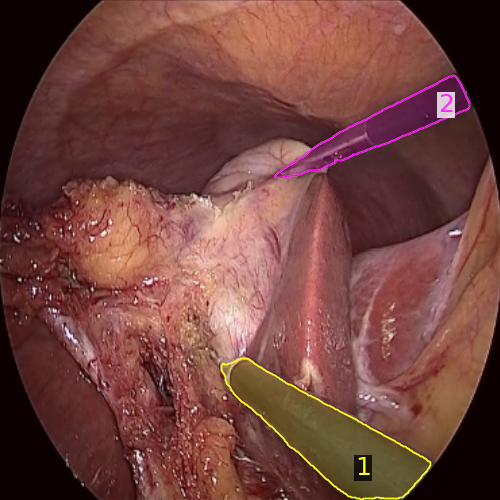

In [ ]:
from functools import partial
from IPython.display import display, Image
import os

from sam3.agent.client_llm import send_generate_request as send_generate_request_orig
from sam3.agent.client_sam3 import call_sam_service as call_sam_service_orig
from sam3.agent.inference import run_single_image_inference

# ---- HERE: OpenAI llm_config & server ----
llm_config = {
    "provider": "openai",
    "model": "gpt-5",                  # choose your model
    "api_key": "",  # make sure this env var is set
    "temperature": 0.2,
    "max_tokens": 512,
    "name": "gpt-5",
}

LLM_SERVER_URL = "https://api.openai.com/v1"

# prepare input args and run single image inference
image = "/home/scanar/endovis/models/sam3/data/Endoscapes2023_Cutmargins/frames/video_001/000029.jpg"
prompt = """
You are a surgical vision assistant collaborating with the SAM 3 segmentation model.
Your goal is to help segment hepatocystic anatomy and tools in laparoscopic cholecystectomy images.

You must work ONLY with the following categories, using these exact names and IDs:

1. cystic_plate (id: 1) – connective tissue plane on the liver surface that supports the gallbladder.
2. calot_triangle (id: 2) – anatomical triangle between the cystic duct, common hepatic duct, and inferior liver border.
3. cystic_artery (id: 3) – artery supplying the gallbladder, usually running to the gallbladder wall.
4. cystic_duct (id: 4) – duct connecting the gallbladder to the biliary tree.
5. gallbladder (id: 5) – sac-like organ attached to the liver, often greenish or yellowish.
6. tool (id: 6) – any visible surgical or laparoscopic instrument (grasper, hook, clip applier, etc.).

TASK:
- Carefully inspect the given image.
- Determine which of the six categories above are clearly visible.
- For EACH visible category, provide precise natural language instructions that SAM3 can use to segment that region.
- If a category is not visible or too ambiguous, explicitly mark it as not visible instead of guessing.

BEHAVIOR:
- Do NOT invent or hallucinate structures that are not clearly present.
- Prefer high precision over recall: if unsure, say "not visible" for that category.
- When describing regions, use clear spatial references (e.g., "thin tubular structure running from the gallbladder neck towards the common bile duct", "triangular fat-filled area between the cystic duct and liver", "metallic grasper holding the gallbladder fundus").

OUTPUT FORMAT (strict):
Return one line per category in this exact order:

cystic_plate: <short segmentation instruction OR "not visible">
calot_triangle: <short segmentation instruction OR "not visible">
cystic_artery: <short segmentation instruction OR "not visible">
cystic_duct: <short segmentation instruction OR "not visible">
gallbladder: <short segmentation instruction OR "not visible">
tool: <short segmentation instruction OR "not visible">

Examples of good instructions:
- "gallbladder: segment the entire pear-shaped sac attached to the liver on the right side of the image"
- "cystic_duct: segment the thin tubular structure leaving the gallbladder neck and running towards the common bile duct"
- "tool: segment the metallic grasper holding the gallbladder at its fundus"

Remember: use ONLY the six categories above and follow the output format exactly.
"""


# This function will internally use the OpenAI API
send_generate_request = partial(
    send_generate_request_orig,
    server_url=LLM_SERVER_URL,
    model=llm_config["model"],
    api_key=llm_config["api_key"],
)

# `processor` must be your Sam3Processor instance created from the SAM3 model
call_sam_service = partial(
    call_sam_service_orig,
    sam3_processor=processor,
)

output_image_path = run_single_image_inference(
    image,
    prompt,
    llm_config,
    send_generate_request,
    call_sam_service,
    debug=True,
    output_dir="agent_output",
)

if output_image_path is not None:
    display(Image(filename=output_image_path))
